## R6- Churn Management - Intro to Neural Networks & Deep Learning

### Setup Environment and Load Necessary Packages (5%)

In [1]:
%tensorflow_version 2.x

#!pip install tensorflow

import os
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras as ks
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.utils import np_utils

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


Using TensorFlow backend.


### Data Preparation (40%)

#### Loading Data (5%)

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pwd
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/
!pwd

bank_cust_demo = pd.read_csv("bank.csv", sep=',')  # , names=["userid", "productid", "ratings", "timestamp"])
type(bank_cust_demo)

/content
/content/gdrive/My Drive/Colab Notebooks
/content/gdrive/My Drive/Colab Notebooks


pandas.core.frame.DataFrame

In [4]:
bank_cust_demo.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Cleaning Data (10%)

In [0]:
bank_cust_demo = bank_cust_demo.drop(columns = ['RowNumber'])
bank_cust_demo = bank_cust_demo.drop(columns = ['CustomerId'])
bank_cust_demo = bank_cust_demo.drop(columns = ['Surname'])

In [6]:
# Missing Values Check

print("The total NOTNULL values in columns is " , sum([True for idx,row in bank_cust_demo.iterrows() if any(row.isnull())]))

The total NOTNULL values in columns is  0


In [7]:
print(bank_cust_demo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None


In [8]:
bank_cust_demo.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [0]:

#sns.pairplot(data=bank_cust_demo.corr(), diag_kind = 'kde', hue = "Exited")

#### Data Representation & Feature Engineering (If Any) (15%)


In [0]:
# Label Encoding 2 fields - Geography and Gender.

bank_cust_demo["Geography"] = LabelEncoder().fit_transform(bank_cust_demo["Geography"])
bank_cust_demo["Gender"] = LabelEncoder().fit_transform(bank_cust_demo["Gender"])

In [0]:
# Label Encoding Age to buckets

for index, row in bank_cust_demo.iterrows():
  #print('Before -> ', row['Age'])
  if (row['Age'] >=18 and row['Age']<24):
    bank_cust_demo.at[index,'Age'] = 1
  else: 
    if (row['Age']>=24 and row['Age']<30):
      bank_cust_demo.at[index,'Age'] =  2
    else: 
      if (row['Age'] >=30 and row['Age']<40):
        bank_cust_demo.at[index,'Age'] =  3
      else:
        if (row['Age'] >=40 and row['Age']<50):
          bank_cust_demo.at[index,'Age'] =  4
        else:
          if (row['Age'] >=50 and row['Age']<60):
            bank_cust_demo.at[index,'Age'] =  5
          else:
            if (row['Age'] >=60 and row['Age']<70):
              bank_cust_demo.at[index,'Age'] =  6
            else:
              if (row['Age'] >=70):
                bank_cust_demo.at[index,'Age'] =  7
  #print('After -> ', bank_cust_demo.at[index,'Age'])


In [0]:
# Label Encoding Credit Score to buckets

for index, row in bank_cust_demo.iterrows():
  #print('Before -> ', row['CreditScore'])
  if (row['CreditScore'] >=350 and row['CreditScore']<550):
    bank_cust_demo.at[index,'CreditScore'] = 1
  else: 
    if (row['CreditScore']>=550 and row['CreditScore']<700):
      bank_cust_demo.at[index,'CreditScore'] =  2
    else: 
      if (row['CreditScore'] >=700 and row['CreditScore']<850):
        bank_cust_demo.at[index,'CreditScore'] =  3
      else:
        if (row['CreditScore'] >=850):
          bank_cust_demo.at[index,'CreditScore'] =  4
  #print('After -> ', bank_cust_demo.at[index,'CreditScore'])


In [0]:
# Label Encoding Balance to buckets

for index, row in bank_cust_demo.iterrows():
  if (row['Balance'] >=0 and row['Balance']<2500):
    bank_cust_demo.at[index,'Balance'] = 1
  else: 
    if (row['Balance']>=2500 and row['Balance']<5000):
      bank_cust_demo.at[index,'Balance'] =  2
    else: 
      if (row['Balance'] >=5000 and row['Balance']<7500):
        bank_cust_demo.at[index,'Balance'] =  3
      else:
        if (row['Balance'] >=7500 and row['Balance']<1000):
          bank_cust_demo.at[index,'Balance'] =  4
        else:
          if (row['Balance'] >=10000 and row['Balance']<15000):
            bank_cust_demo.at[index,'Balance'] =  5
          else:
            if (row['Balance'] >=15000 and row['Balance']<20000):
              bank_cust_demo.at[index,'Balance'] =  6
            else:
              if (row['Balance'] >=20000):
                bank_cust_demo.at[index,'Balance'] =  7
  #print('After -> ', bank_cust_demo.at[index,'Age'])

In [14]:
bank_cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null int64
Gender             10000 non-null int64
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9)
memory usage: 859.5 KB


In [0]:

bank_cust_demo_age_OHE = pd.get_dummies(bank_cust_demo['Age'], prefix = 'Age') # columns = ['Age_18-24','Age_24-30','Age_30-40','Age_40-50','Age_50-60','Age_60-70','Age_70'])
#bank_cust_demo_age_OHE.head(3)
bank_cust_demo = pd.concat([bank_cust_demo, bank_cust_demo_age_OHE],axis = 1)
bank_cust_demo.drop(columns ='Age',inplace = True)

In [0]:
bank_cust_demo_CreditScore_OHE = pd.get_dummies(bank_cust_demo['CreditScore'], prefix = 'CreditScore') 
bank_cust_demo = pd.concat([bank_cust_demo, bank_cust_demo_CreditScore_OHE],axis = 1)
bank_cust_demo.drop(columns ='CreditScore',inplace = True)

In [0]:
bank_cust_demo_Balance_OHE = pd.get_dummies(bank_cust_demo['Balance'], prefix = 'Balance') 
bank_cust_demo = pd.concat([bank_cust_demo, bank_cust_demo_Balance_OHE],axis = 1)
bank_cust_demo.drop(columns ='Balance',inplace = True)

In [0]:
bank_cust_demo_Gender_OHE = pd.get_dummies(bank_cust_demo['Gender'], prefix = 'Gender') 
bank_cust_demo = pd.concat([bank_cust_demo, bank_cust_demo_Gender_OHE],axis = 1)
bank_cust_demo.drop(columns ='Gender',inplace = True)

In [0]:
bank_cust_demo_Geography_OHE = pd.get_dummies(bank_cust_demo['Geography'], prefix = 'Geography') 
bank_cust_demo = pd.concat([bank_cust_demo, bank_cust_demo_Geography_OHE],axis = 1)
bank_cust_demo.drop(columns ='Geography',inplace = True)

In [20]:
type(bank_cust_demo)
bank_cust_demo.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00
Age_1,10000.0,0.032500,0.177333,0.00,0.00,0.000,0.0000,1.00
Age_2,10000.0,0.131600,0.338072,0.00,0.00,0.000,0.0000,1.00
Age_3,10000.0,0.434600,0.495729,0.00,0.00,0.000,1.0000,1.00
Age_4,10000.0,0.261800,0.439636,0.00,0.00,0.000,1.0000,1.00


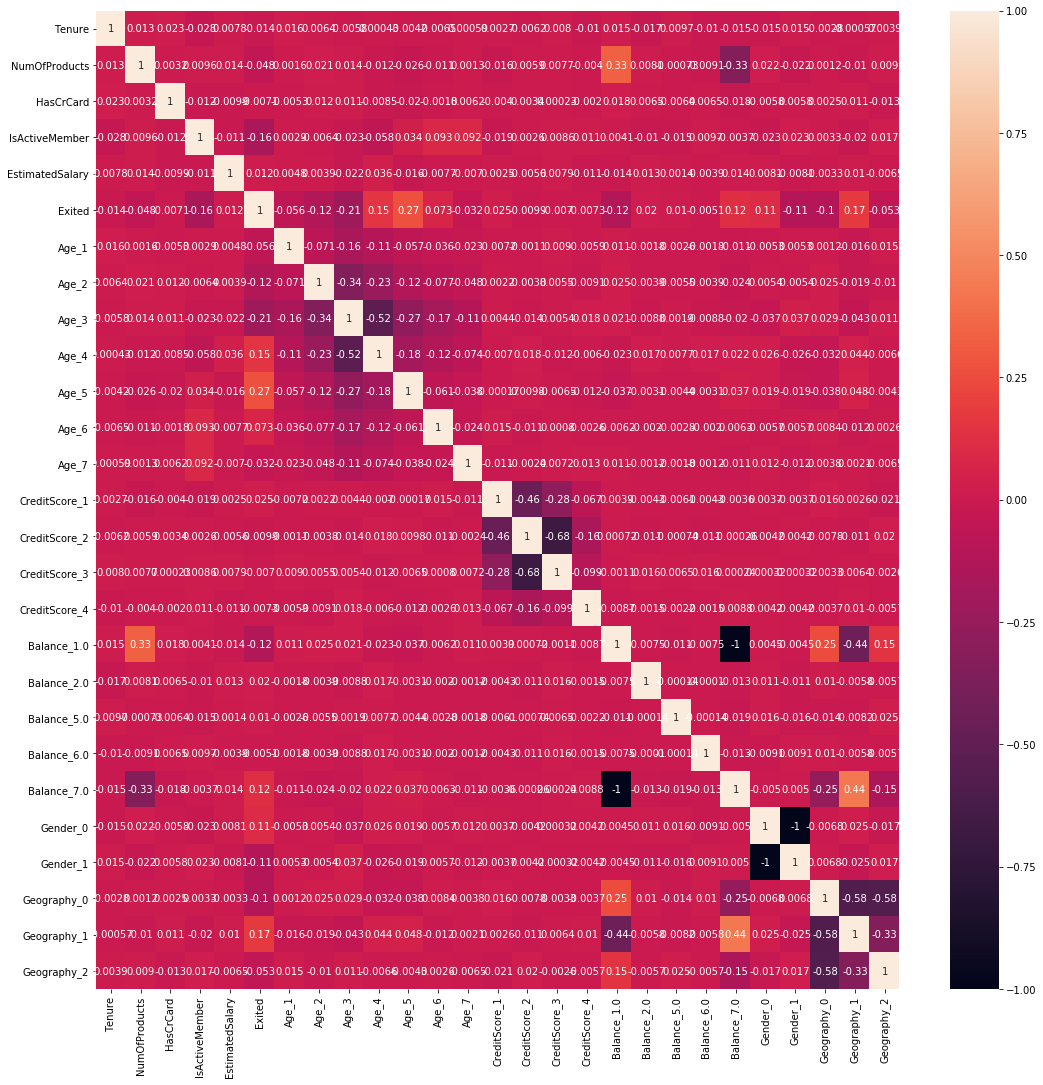

In [21]:
import matplotlib.pyplot as mplot

mplot.figure(figsize=(18 , 18))
bank_cust_demo_corr = bank_cust_demo.corr()
sns.heatmap(bank_cust_demo.corr(), xticklabels = bank_cust_demo_corr.columns.values, yticklabels = bank_cust_demo_corr.columns.values, annot = True);


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 1584x1584 with 0 Axes>

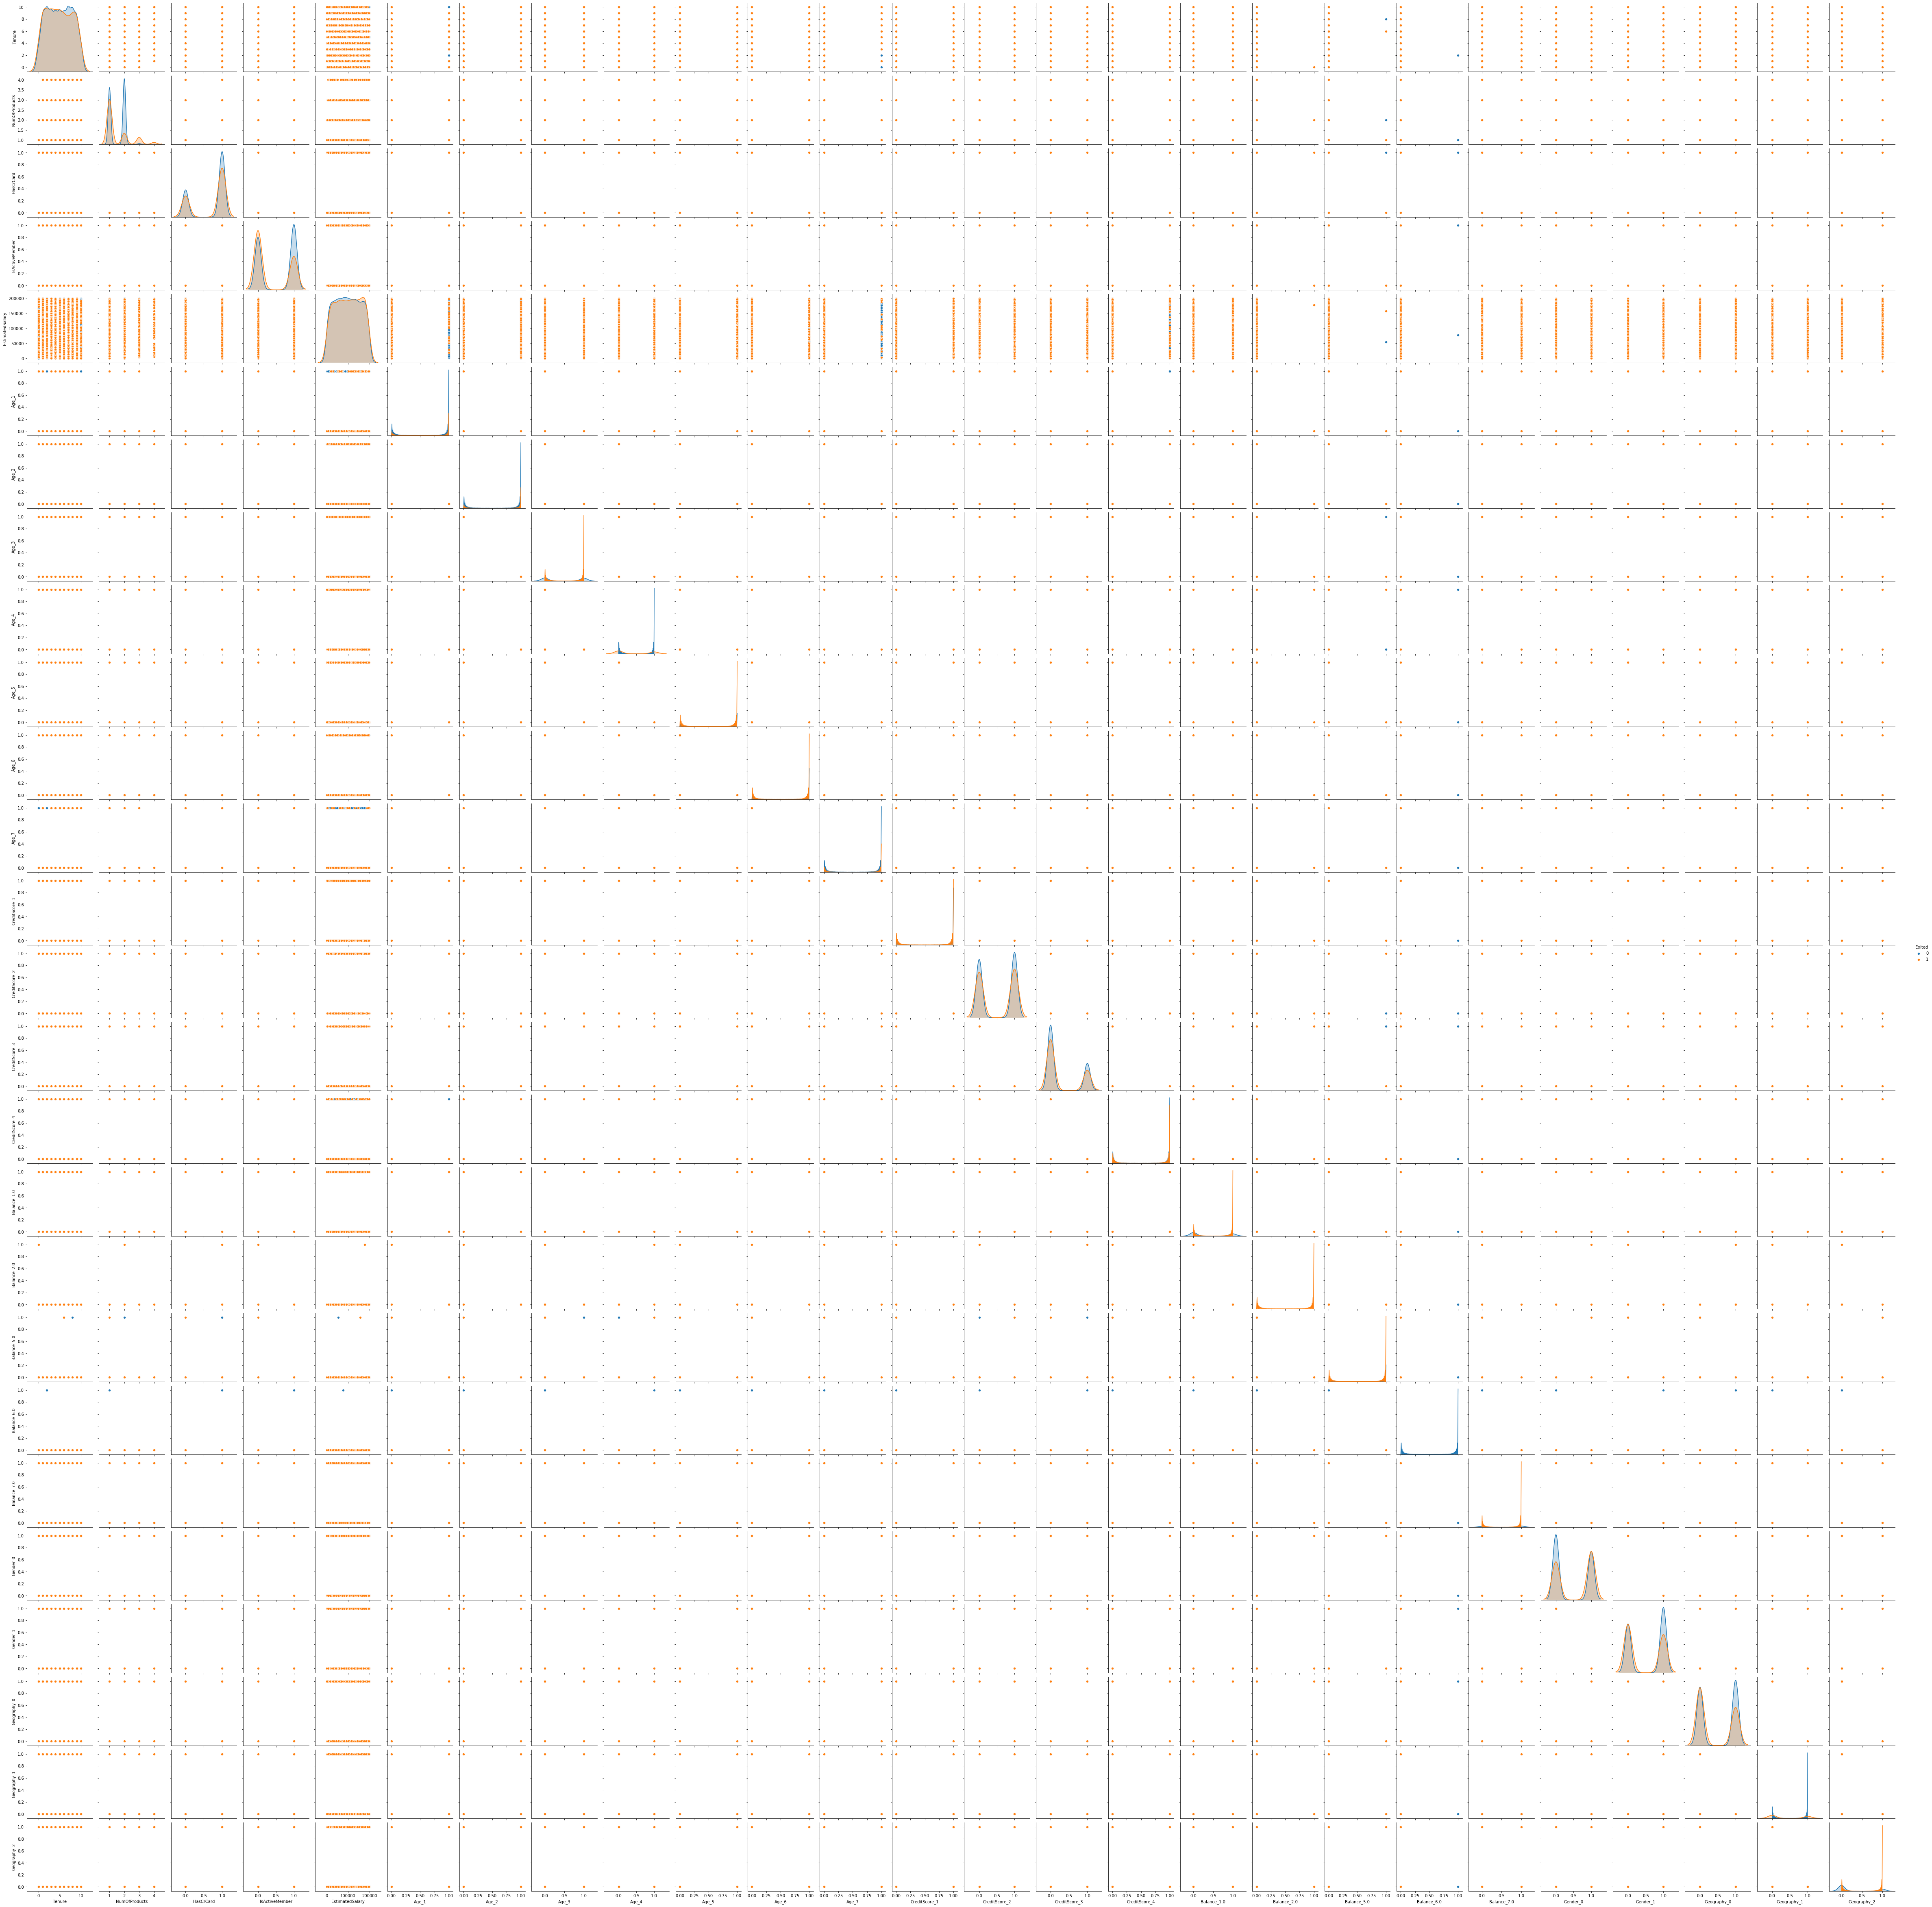

In [22]:

mplot.figure(figsize=(22 , 22))
sns.pairplot(data=bank_cust_demo, diag_kind = 'kde', hue ="Exited")

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Creating Train and Validation Set (10%)

In [24]:
# split data into X and y
y_ML = bank_cust_demo["Exited"]
X_ML = bank_cust_demo.drop(columns = ['Exited'])

print(type(y_ML))
print(type(X_ML))

X = X_ML
y = y_ML 
# Converting to array for neural net consumption.
#X = np.array(X_ML)
#y = np.array(y_ML)

print(type(X))
print(type(y))
print(bank_cust_demo.shape)
print(X.shape)
print(y.shape)

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(10000, 27)
(10000, 26)
(10000,)


In [0]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

X_train_ML , X_test_ML , y_train_ML,   y_test_ML  = train_test_split(X_ML, y_ML, test_size=0.50, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# SMOTE data for handling Target data imbalance.

#smt = SMOTE()
#X_train, y_train = smt.fit_sample(X_train, y_train)
#print(y_train)

#smt = SMOTE()
#X_train_ML, y_train_ML = smt.fit_sample(X_train_ML, y_train_ML)
#print(y_train)

In [0]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes = 2 )
y_test = to_categorical(y_test, num_classes = 2 )


In [0]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)


## Model Creation (30%)

In [0]:
XGB = XGBClassifier()

In [29]:
#model_seq =Sequential()
model_seq = tf.keras.Sequential()
input_shape = X_train[0].shape
print(input_shape)
#Input Layer
model_seq.add(Dense(units=10, activation='relu',input_shape= input_shape))
model_seq.add(Dense(20, activation ='relu'))
model_seq.add(Dense(30, activation ='relu'))
model_seq.add(Dense(30, activation = 'relu'))
model_seq.add(Dense(2,activation='softmax'))

(26,)


#### Write & Configure Model (10%)

In [0]:
XGB.max_depth = 3
XGB.n_estimators = 50
XGB.booster = 'gbtree'
XGB.random_state = 0

#### Compile Model (10%)

In [31]:
XGB.fit(X_train_ML, y_train_ML)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# make predictions for test data

y_pred_XGB = XGB.predict(X_test_ML)     
predict_XGB = [round(value) for value in y_pred_XGB]

In [0]:
from keras import optimizers

#sgd = optimizers.sgd(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#Adamax = optimizers.Adamax(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#adadelta = optimizers.Adadelta(lr=0.01)

model_seq.compile(loss='binary_crossentropy',optimizer='SGD',metrics=['accuracy'])
#model_seq.compile(loss='binary_crossentropy',optimizer='Adamax',metrics=['accuracy'])
#model_seq.compile(loss='categorical_crossentropy',optimizer='Adadelta',metrics=['accuracy'])

#model_seq.compile(loss='binary_crossentropy',optimizer='Adamax',metrics=['accuracy'], learning_rate=0.1)
#model_seq.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
#model_seq.compile(loss='categorical_crossentropy',optimizer='Adadelta',metrics=['accuracy'])
#model_seq.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_seq.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy']) 
#model_seq.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])
#model_seq.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])

#### Build Model & Checking Summary (10%)

In [34]:
# evaluate predictions
accuracy_XGB = accuracy_score(y_test_ML, y_pred_XGB)
print("XGB Accuracy: %.2f%%" % (accuracy_XGB * 100.0))

XGB Accuracy: 85.52%


In [35]:
model_seq.fit(X_train,y_train,epochs=100,verbose=1,validation_data=(X_test,y_test))

Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 2s 239us/sample - loss: 0.5583 - accuracy: 0.7623 - val_loss: 0.5077 - val_accuracy: 0.7930
Epoch 2/100
7000/7000 [==============================] - 0s 69us/sample - loss: 0.4909 - accuracy: 0.7977 - val_loss: 0.4864 - val_accuracy: 0.7937
Epoch 3/100
7000/7000 [==============================] - 1s 74us/sample - loss: 0.4699 - accuracy: 0.8007 - val_loss: 0.4642 - val_accuracy: 0.8003
Epoch 4/100
7000/7000 [==============================] - 1s 74us/sample - loss: 0.4493 - accuracy: 0.8099 - val_loss: 0.4450 - val_accuracy: 0.8093
Epoch 5/100
7000/7000 [==============================] - 1s 74us/sample - loss: 0.4347 - accuracy: 0.8169 - val_loss: 0.4325 - val_accuracy: 0.8170
Epoch 6/100
7000/7000 [==============================] - 0s 67us/sample - loss: 0.4257 - accuracy: 0.8187 - val_loss: 0.4239 - val_accuracy: 0.8180
Epoch 7/100
7000/7000 [==============================] - 0s 67u

In [36]:
model_seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 62        
Total params: 2,112
Trainable params: 2,112
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_seq_predict = model_seq.predict(X_test, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
#seq_keras_model.metrics
print(type(model_seq_predict))
#model_seq_predict = np.round(model_seq_predict,0)
print(model_seq_predict)

<class 'numpy.ndarray'>
[[0.69129455 0.30870545]
 [0.4650607  0.5349392 ]
 [0.7764018  0.22359814]
 ...
 [0.87717116 0.12282886]
 [0.96317255 0.03682744]
 [0.48943675 0.51056325]]


In [0]:
model_seq_predict = pd.DataFrame(model_seq_predict)
model_seq_predict = model_seq_predict.idxmax(axis=1)

y_actual = pd.DataFrame(y_test)
y_actual = y_actual.idxmax(axis=1)

In [0]:
#from sklearn.metrics import confusion_matrix
#model_seq_predict = np.argmax(model_seq_predict, axis = 1)
#X_test = np.argmax(X_test)

In [40]:
results = confusion_matrix(y_actual.round() , model_seq_predict.round()) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score in TEST :',accuracy_score(y_actual, model_seq_predict))
print('Report : ')
print(classification_report(y_actual, model_seq_predict))

Confusion Matrix :
[[2245  134]
 [ 301  320]]
Accuracy Score in TEST : 0.855
Report : 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2379
           1       0.70      0.52      0.60       621

    accuracy                           0.85      3000
   macro avg       0.79      0.73      0.75      3000
weighted avg       0.85      0.85      0.85      3000



In [41]:
print("  SUMMARY ")
print("XGBOOST gave a accuracy of 85.56% ")
print(" Optimizers -> BINARY Crossentropy and Categorical crossentropy gives the same accuracy score around 85%")
print(" There is imbalance in the Target dataset, hence SMOTE was done. But it reduced the accuracy score to less than 84%. Hence commented the run of SMOTE of data.")
print("One Hot Encoding was done for multiple columns after binning. Age , Credit Score, Balance, Gender, Geography. It didn't improve any accuracy score.")


  SUMMARY 
XGBOOST gave a accuracy of 85.56% 
BINARY Crossentropy and Categorical crossentropy gives the same accuracy score @ 85%
 There is imbalance in the Target dataset, hence SMOTE was done. But it reduced the accuracy score to less than 84%. Hence commented the run of SMOTE of data.
